In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import struct
import subprocess
import sys

In [102]:
base_dir = '/Users/matteo/Documents/GitHub/SpatialAQP/test/index_query'
exec_dir = "../.."
print(base_dir)

/Users/matteo/Documents/GitHub/SpatialAQP/test/index_query


In [103]:
def generate_records(nrec, minval, maxval):
    rec = []
    for i in range(0, nrec):
        x = random.uniform(minval, maxval)
        y = random.uniform(minval, maxval)
        rec.append((x,y))
    return rec

In [104]:
def write_records(filename, rec):
    f = open(filename, 'wb')
    for r in rec:
        f.write(struct.pack('>dd', r[0], r[1]))
    f.close()

In [105]:
def generate_fraction(nrec, S, Q, f):
    rec = []
    # compute the fraction of matching records
    qrec = int(round(f * nrec))
    # generate the matching records
    for i in range(0, qrec):
        x = random.uniform(Q[0], Q[2])
        y = random.uniform(Q[1], Q[3])
        rec.append((x,y))
    # now generate the non matching records
    i = 0
    remaining = nrec - qrec
    while (i < remaining):
        x = random.uniform(S[0], S[2])
        y = random.uniform(S[1], S[3])
        # try to change the middle or to and
        if ((not (Q[0] <= x and x <= Q[2])) or (not (Q[1] <= y and y <= Q[3]))):
            rec.append((x,y))
            i += 1
    random.shuffle(rec)
    return rec

In [106]:
def compute_fraction(rec, Q):
    count = 0
    for r in rec:
        x = r[0]
        y = r[1]
        if (Q[0] <= x and x <= Q[2] and Q[1] <= y and y <= Q[3]):
            count += 1
    return (count / len(rec))

---

In [109]:
# Generate the test cases.
m = 100000
Q = (0, 0, 100, 100)
S = (-1000, -1000, 1000, 1000)
frac = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

os.chdir(base_dir)

for f in frac:
    fp = int(f * 100)
    print('Generating m={} records with f={}%...'.format(m, fp))
    filename = 'frecords_m={}_f={}.bin'.format(m, fp)
    rec = generate_fraction(m, S, Q, f)
    write_records(filename, rec)
    
print('Done!')

Generating m=100000 records with f=10%...
Generating m=100000 records with f=20%...
Generating m=100000 records with f=30%...
Generating m=100000 records with f=40%...
Generating m=100000 records with f=50%...
Generating m=100000 records with f=60%...
Generating m=100000 records with f=70%...
Generating m=100000 records with f=80%...
Generating m=100000 records with f=90%...
Done!


In [113]:
# Test the implementation.

ntrials = 5
m = 100000
c = 100
Q = (0, 0, 100, 100)
S = (-1000, -1000, 1000, 1000)
frac = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
outfile_name = "variable_f.csv"

os.chdir(base_dir)

outfile_p = open(outfile_name, 'w')

os.chdir(exec_dir)

for f in frac:
    fp = int(f * 100)
    print('Testing m={} records with f={}%...'.format(m, fp))
    input_file = "{}/frecords_m={}_f={}.bin".format(base_dir, m, fp)
    query = 0
    verif = 0
    retur = 0
    match = 0
    for i in range(0, ntrials):
        p = subprocess.run(["java", "TestQuery", input_file, 
            str(c), str(Q[0]), str(Q[1]), str(Q[2]), str(Q[3])], 
            capture_output=True)
        lines = p.stdout.decode('utf-8').splitlines()
        #print("root = " + (lines[0].split(' '))[2])
        #print("reconstructed = " + (lines[1].split(' '))[2])
        query += int((lines[3].split(' '))[2])
        verif += int((lines[4].split(' '))[2])
        retur += int((lines[5].split(' '))[2])
        match += int((lines[6].split(' '))[2])
    query /= ntrials
    verif /= ntrials
    retur /= ntrials
    match /= ntrials
    outfile_p.write('{},{},{},{},{}\n'.format(f, query, verif, retur, match))
    
outfile_p.close()

print("Done!")

os.chdir(base_dir)

Testing m=100000 records with f=10%...
Testing m=100000 records with f=20%...
Testing m=100000 records with f=30%...
Testing m=100000 records with f=40%...
Testing m=100000 records with f=50%...
Testing m=100000 records with f=60%...
Testing m=100000 records with f=70%...
Testing m=100000 records with f=80%...
Testing m=100000 records with f=90%...
Done!


In [114]:
pd.set_option("display.precision", 3)
df1 = pd.read_csv('variable_f.csv', header=None)
df1.columns = ['f', 'avg query time', 'avg verif time', 'returned', 'matching']
df1.sort_values(ascending=True, by='f', inplace=True)
df1['avg query time'] /= 1000000
df1['avg verif time'] /= 1000000
df1

,f,avg query time,avg verif time,returned,matching
0,0.1,3.600,15.486,20000.0,10000.0
1,0.2,4.880,34.524,40000.0,20000.0
2,0.3,4.694,30.124,40000.0,30000.0
3,0.4,5.138,40.156,50000.0,40000.0
4,0.5,5.898,48.759,60000.0,50000.0
5,0.6,6.748,64.602,70000.0,60000.0
6,0.7,7.167,67.411,80000.0,70000.0
7,0.8,6.631,68.127,90000.0,80000.0
8,0.9,7.387,68.912,100000.0,90000.0


In [115]:
print(df1.to_latex(index=False, escape=False))

\begin{tabular}{rrrrr}
\toprule
   f &  avg query time &  avg verif time &  returned &  matching \\
\midrule
 0.1 &           3.600 &          15.486 &   20000.0 &   10000.0 \\
 0.2 &           4.880 &          34.524 &   40000.0 &   20000.0 \\
 0.3 &           4.694 &          30.124 &   40000.0 &   30000.0 \\
 0.4 &           5.138 &          40.156 &   50000.0 &   40000.0 \\
 0.5 &           5.898 &          48.759 &   60000.0 &   50000.0 \\
 0.6 &           6.748 &          64.602 &   70000.0 &   60000.0 \\
 0.7 &           7.167 &          67.411 &   80000.0 &   70000.0 \\
 0.8 &           6.631 &          68.127 &   90000.0 &   80000.0 \\
 0.9 &           7.387 &          68.912 &  100000.0 &   90000.0 \\
\bottomrule
\end{tabular}



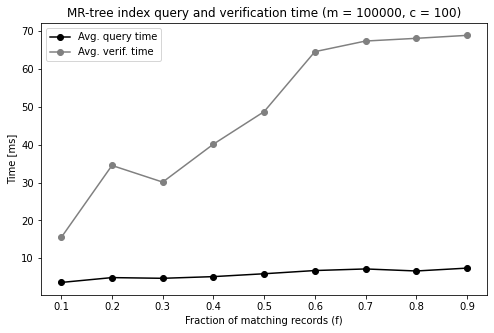

In [119]:
plt.figure(figsize=(8, 5))
plt.title("MR-tree index query and verification time (m = 100000, c = 100)")
#plt.plot(res['n'], res['mat_time'], color='gray', label='Matlab')
plt.plot(df1['f'], df1['avg query time'], marker='o', color='black', label="Avg. query time")
plt.plot(df1['f'], df1['avg verif time'], marker='o', color='grey', label="Avg. verif. time")
plt.ylabel("Time [ms]")
plt.xlabel("Fraction of matching records (f)")
#plt.plot([x for x in range(100, 100000)], [x*np.log(x) for x in range(100, 100000)], color='black', linestyle='--')
plt.legend()
plt.savefig("test_query_fraction.png", dpi=170, format='png', bbox_inches='tight')

---

For the next experiment...

In [43]:
base_dir = '/Users/matteo/Documents/GitHub/SpatialAQP/test/index_query'
exec_dir = "../.."

In [39]:
# We generate 10 different data sets with 40% matching records. 
Q = (0, 0, 100, 100)
S = (-1000, -1000, 1000, 1000)
f = 0.4
sizes = [50000, 100000, 150000, 200000, 250000, 300000, 350000, 400000, 450000, 500000]

os.chdir(base_dir)

for m in sizes:
    print("Generating m={} records...".format(m))
    rec = generate_fraction(m, S, Q, f)
    filename = 'records_m={}_f=40.bin'.format(m)
    write_records(filename, rec)

print('Done!')

Generating m=50000 records...
Generating m=100000 records...
Generating m=150000 records...
Generating m=200000 records...
Generating m=250000 records...
Generating m=300000 records...
Generating m=350000 records...
Generating m=400000 records...
Generating m=450000 records...
Generating m=500000 records...
Done!


In [65]:
# Test the implementation.
ntrials = 5
outf_name = 'variable_m.csv'
c = 100
Q = (0, 0, 100, 100)
S = (-1000, -1000, 1000, 1000)
sizes = [50000, 100000, 150000, 200000, 250000, 300000, 350000, 400000, 450000, 500000]

os.chdir(base_dir)

outfp = open(outf_name, 'w')

os.chdir(exec_dir)

for m in sizes:
    print('Testing m={} records with f=40%...'.format(m, fp))
    input_file = "{}/records_m={}_f=40.bin".format(base_dir, m)
    query = 0
    verif = 0
    retur = 0
    match = 0
    for i in range(0, ntrials):
        p = subprocess.run(["java", "TestQuery", input_file, 
            str(c), str(Q[0]), str(Q[1]), str(Q[2]), str(Q[3])], 
            capture_output=True)
        lines = p.stdout.decode('utf-8').splitlines()
        query += int((lines[3].split(' '))[2])
        verif += int((lines[4].split(' '))[2])
        retur += int((lines[5].split(' '))[2])
        match += int((lines[6].split(' '))[2])
    query /= ntrials
    verif /= ntrials
    retur /= ntrials
    match /= ntrials
    outfp.write('{},{},{},{},{}\n'.format(m, query, verif, retur, match))
    
outfp.close()

print("Done!")

os.chdir(base_dir)

Testing m=50000 records with f=40%...
Testing m=100000 records with f=40%...
Testing m=150000 records with f=40%...
Testing m=200000 records with f=40%...
Testing m=250000 records with f=40%...
Testing m=300000 records with f=40%...
Testing m=350000 records with f=40%...
Testing m=400000 records with f=40%...
Testing m=450000 records with f=40%...
Testing m=500000 records with f=40%...
Done!


In [66]:
pd.set_option("display.precision", 3)
df = pd.read_csv('variable_m.csv', header=None)
df.columns = ['m', 'avg query time', 'avg verif time', 'returned', 'matching']
df.sort_values(ascending=True, by='m', inplace=True)
df['avg query time'] /= 1000000
df['avg verif time'] /= 1000000
df

,m,avg query time,avg verif time,returned,matching
0,50000,3.719,16.016,30000.0,20000.0
1,100000,4.840,35.019,50000.0,40000.0
2,150000,5.793,58.733,70000.0,60000.0
3,200000,5.333,53.691,100000.0,80000.0
4,250000,5.727,73.152,120000.0,100000.0
5,300000,7.231,74.855,140000.0,120000.0
6,350000,7.289,88.221,160000.0,140000.0
7,400000,8.878,96.069,180000.0,160000.0
8,450000,15.756,98.373,200000.0,180000.0
9,500000,9.471,98.786,220000.0,200000.0


In [67]:
print(df.to_latex(index=False, escape=False))

\begin{tabular}{rrrrr}
\toprule
      m &  avg query time &  avg verif time &  returned &  matching \\
\midrule
  50000 &           3.719 &          16.016 &   30000.0 &   20000.0 \\
 100000 &           4.840 &          35.019 &   50000.0 &   40000.0 \\
 150000 &           5.793 &          58.733 &   70000.0 &   60000.0 \\
 200000 &           5.333 &          53.691 &  100000.0 &   80000.0 \\
 250000 &           5.727 &          73.152 &  120000.0 &  100000.0 \\
 300000 &           7.231 &          74.855 &  140000.0 &  120000.0 \\
 350000 &           7.289 &          88.221 &  160000.0 &  140000.0 \\
 400000 &           8.878 &          96.069 &  180000.0 &  160000.0 \\
 450000 &          15.756 &          98.373 &  200000.0 &  180000.0 \\
 500000 &           9.471 &          98.786 &  220000.0 &  200000.0 \\
\bottomrule
\end{tabular}



---

In [69]:
Q = (0, 0, 100, 100)
S = (-1000, -1000, 1000, 1000)
f = 0.3
m = 300000

os.chdir(base_dir)

print("Generating m={} records...".format(m))
rec = generate_fraction(m, S, Q, f)
filename = 'records_m={}_f={}.bin'.format(m, int(f*100))
write_records(filename, rec)

print('Done!')

Generating m=300000 records...
Done!


In [70]:
#
# 
#

ntrials = 5
outf2_name = 'variable_c.csv'
capacities = [10, 25, 50, 75, 100, 250, 500, 750, 1000, 2500, 7500, 10000]
Q = (0, 0, 100, 100)
S = (-1000, -1000, 1000, 1000)
input_file = "{}/records_m=300000_f=30.bin".format(base_dir)

os.chdir(base_dir)

outfp2 = open(outf2_name, 'w')

os.chdir(exec_dir)

for c in capacities:
    print('Testing capacity c={}...'.format(c))
    query = 0
    verif = 0
    retur = 0
    match = 0
    for i in range(0, ntrials):
        p = subprocess.run(["java", "TestQuery", input_file, 
            str(c), str(Q[0]), str(Q[1]), str(Q[2]), str(Q[3])], 
            capture_output=True)
        lines = p.stdout.decode('utf-8').splitlines()
        query += int((lines[3].split(' '))[2])
        verif += int((lines[4].split(' '))[2])
        retur += int((lines[5].split(' '))[2])
        match += int((lines[6].split(' '))[2])
    query /= ntrials
    verif /= ntrials
    retur /= ntrials
    match /= ntrials
    outfp2.write('{},{},{},{},{}\n'.format(c, query, verif, retur, match))
    
outfp2.close()

print("Done!")

os.chdir(base_dir)

Testing capacity c=10...
Testing capacity c=25...
Testing capacity c=50...
Testing capacity c=75...
Testing capacity c=100...
Testing capacity c=250...
Testing capacity c=500...
Testing capacity c=750...
Testing capacity c=1000...
Testing capacity c=2500...
Testing capacity c=7500...
Testing capacity c=10000...
Done!


In [71]:
pd.set_option("display.precision", 3)
df = pd.read_csv('variable_c.csv', header=None)
df.columns = ['c', 'avg query time', 'avg verif time', 'returned', 'matching']
df.sort_values(ascending=True, by='c', inplace=True)
df['avg query time'] /= 1000000
df['avg verif time'] /= 1000000
df

,c,avg query time,avg verif time,returned,matching
0,10,17.897,133.381,100100.0,90000.0
1,25,11.676,75.945,100625.0,90000.0
2,50,9.392,72.760,102500.0,90000.0
3,75,9.113,73.360,106875.0,90000.0
4,100,6.791,66.795,110000.0,90000.0
5,250,5.328,85.358,187500.0,90000.0
6,500,4.297,100.476,250000.0,90000.0
7,750,3.997,112.201,300000.0,90000.0
8,1000,3.864,101.093,300000.0,90000.0
9,2500,2.583,94.965,300000.0,90000.0


In [72]:
print(df.to_latex(index=False, escape=False))

\begin{tabular}{rrrrr}
\toprule
     c &  avg query time &  avg verif time &  returned &  matching \\
\midrule
    10 &          17.897 &         133.381 &  100100.0 &   90000.0 \\
    25 &          11.676 &          75.945 &  100625.0 &   90000.0 \\
    50 &           9.392 &          72.760 &  102500.0 &   90000.0 \\
    75 &           9.113 &          73.360 &  106875.0 &   90000.0 \\
   100 &           6.791 &          66.795 &  110000.0 &   90000.0 \\
   250 &           5.328 &          85.358 &  187500.0 &   90000.0 \\
   500 &           4.297 &         100.476 &  250000.0 &   90000.0 \\
   750 &           3.997 &         112.201 &  300000.0 &   90000.0 \\
  1000 &           3.864 &         101.093 &  300000.0 &   90000.0 \\
  2500 &           2.583 &          94.965 &  300000.0 &   90000.0 \\
  7500 &           2.292 &          87.771 &  300000.0 &   90000.0 \\
 10000 &           2.347 &          90.274 &  300000.0 &   90000.0 \\
\bottomrule
\end{tabular}



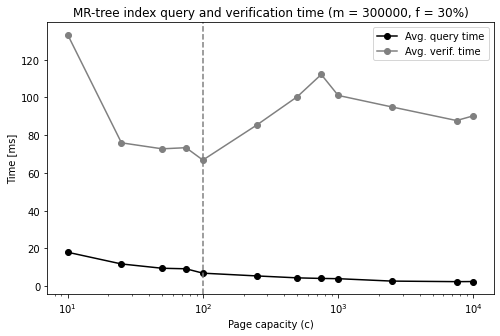

In [101]:
plt.figure(figsize=(8, 5))
plt.title("MR-tree index query and verification time (m = 300000, f = 30%)")
plt.xticks(df['c'])
plt.xscale('log')
plt.plot(df['c'], df['avg query time'], marker='o', color='black', label='Avg. query time')
plt.plot(df['c'], df['avg verif time'], marker='o', color='grey', label='Avg. verif. time')
plt.axvline(100, 0, 1, color='gray', linestyle='--')
plt.ylabel("Time [ms]")
plt.xlabel("Page capacity (c)")
plt.legend()
plt.savefig("test_query_capacity.png", dpi=170, format='png', bbox_inches='tight')